## Imputing data - IterativeImputer and RandomForestClassifier

### Libraries

In [110]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

### Introducing random missing data to the iris data set

In [111]:
df = load_iris()

In [112]:
target = df.target

In [113]:
df = pd.DataFrame(data=df.data, columns=df.feature_names)

In [114]:
target = pd.Series(target)

In [115]:
df["target"] = target

In [116]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [117]:
df.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target                 int32
dtype: object

In [118]:
np.random.seed(42)

fraction_of_nan = 0.05  


mask = np.random.rand(*df.shape) < fraction_of_nan


df[mask] = np.nan


print(df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  NaN               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0       0.0  

### Inspecting missing values

In [119]:
missing_df = df.isna().sum().sort_values(ascending=False).reset_index(name="missing_values")

In [120]:
missing_df_perc = missing_df.copy()

In [121]:
missing_df_perc["missing_values"] = missing_df_perc["missing_values"].apply(lambda x: round(x/df.shape[0],4))

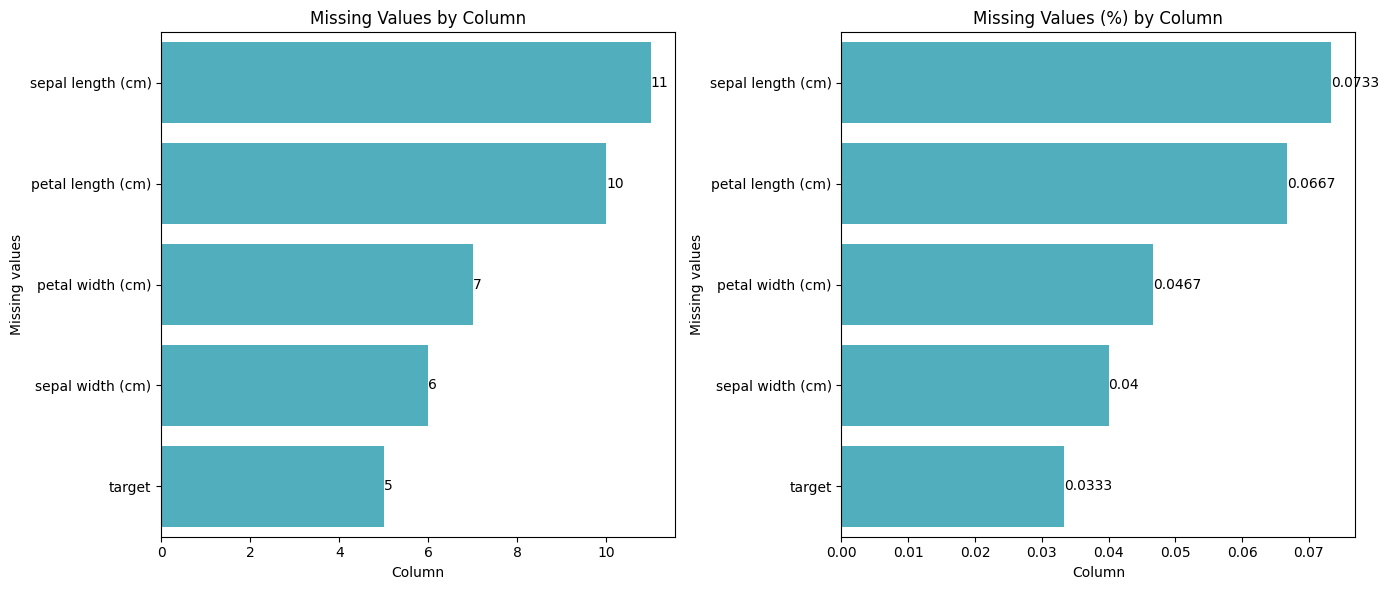

In [122]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize = (14,6))
axes = axes.flatten()

bar = sns.barplot(data=missing_df,
            y="index",
            x="missing_values",
            color='#3FBBCF',
            ax=axes[0])
for container in bar.containers:
    axes[0].bar_label(container)
axes[0].set_title("Missing Values by Column")
axes[0].set_xlabel("Column")
axes[0].set_ylabel("Missing values")

bar = sns.barplot(data=missing_df_perc,
            y="index",
            x="missing_values",
            color='#3FBBCF',
            ax=axes[1])
for container in bar.containers:
    axes[1].bar_label(container)
axes[1].set_title("Missing Values (%) by Column")
axes[1].set_xlabel("Column")
axes[1].set_ylabel("Missing values")


plt.tight_layout()
plt.show()

In [123]:
df.isna().sum().sort_values(ascending=False)

sepal length (cm)    11
petal length (cm)    10
petal width (cm)      7
sepal width (cm)      6
target                5
dtype: int64

In [124]:
df["target"] = df["target"].astype("object")

In [125]:
df.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target                object
dtype: object

### Using iterative imputer to impute numerical data

In [126]:
df_numeric = df[df.select_dtypes(np.number).columns]

In [128]:
df_numeric[df_numeric.isna().any(axis=1)]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
2,NaN,3.2,1.3,0.2
8,4.4,2.9,NaN,0.2
11,4.8,3.4,1.6,NaN
14,5.8,4.0,NaN,0.2
19,5.1,3.8,1.5,NaN
20,NaN,3.4,1.7,0.2
25,5.0,3.0,1.6,NaN
29,NaN,3.2,1.6,0.2
33,5.5,4.2,1.4,NaN
34,4.9,NaN,1.5,0.2


In [130]:
df_numeric.describe().round(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,139.00,144.00,140.00,143.00
mean,5.86,3.06,3.78,1.22
std,0.82,0.44,1.79,0.75
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.35
50%,5.80,3.00,4.40,1.30
75%,6.40,3.40,5.10,1.80
max,7.90,4.40,6.90,2.50


In [131]:
df_numeric.corr().round(4)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.0000,-0.1333,0.8741,0.8119
sepal width (cm),-0.1333,1.0000,-0.4298,-0.3678
petal length (cm),0.8741,-0.4298,1.0000,0.9604
petal width (cm),0.8119,-0.3678,0.9604,1.0000


In [132]:
iterative_imp = IterativeImputer(max_iter = 25)
imputed_numerical_data = iterative_imp.fit_transform(df_numeric)

In [141]:
imputed_numerical_data = pd.DataFrame(imputed_numerical_data,
             columns = df_numeric.columns)

In [158]:
print('Means of numerical data BEFORE iterative imputation\n')
print(df_numeric.describe().iloc[1,:])
print('\n')
print('Means of numerical data AFTER iterative imputation\n')
print(imputed_numerical_data.describe().iloc[1,:])

Means of numerical data BEFORE iterative imputation

sepal length (cm)    5.855396
sepal width (cm)     3.062500
petal length (cm)    3.783571
petal width (cm)     1.222378
Name: mean, dtype: float64


Means of numerical data AFTER iterative imputation

sepal length (cm)    5.844883
sepal width (cm)     3.061731
petal length (cm)    3.759475
petal width (cm)     1.200728
Name: mean, dtype: float64


In [162]:
df[df.select_dtypes(np.number).columns] = imputed_numerical_data

In [163]:
df.isna().sum().sort_values(ascending=False)

target               5
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
dtype: int64

### Using random forest to impute categorical data

In [168]:
target_missing = df[df.isna().any(axis=1)]

In [169]:
target_missing

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
5,5.4,3.9,1.700000,0.4,NaN
48,5.3,3.7,1.500000,0.2,NaN
66,5.6,3.0,4.029854,1.5,NaN
102,7.1,3.0,5.900000,2.1,NaN
119,6.0,2.2,5.000000,1.5,NaN


In [170]:
target_missing.index

Int64Index([5, 48, 66, 102, 119], dtype='int64')

In [171]:
df.drop(index = [5, 48, 66, 102, 119],inplace=True)

In [178]:
df = df.reset_index(drop=True)

In [179]:
df.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.10000,3.5,1.400000,0.2,0.0
1,4.90000,3.0,1.400000,0.2,0.0
2,4.74108,3.2,1.300000,0.2,0.0
3,4.60000,3.1,1.500000,0.2,0.0
4,5.00000,3.6,1.400000,0.2,0.0
5,4.60000,3.4,1.400000,0.3,0.0
6,5.00000,3.4,1.500000,0.2,0.0
7,4.40000,2.9,1.355945,0.2,0.0
8,4.90000,3.1,1.500000,0.1,0.0
9,5.40000,3.7,1.500000,0.2,0.0


In [184]:
df["target"] = df["target"].astype(np.number)

In [186]:
rf_mod = RandomForestClassifier(n_estimators=100)
rf_mod.fit(df.drop("target",axis=1), df["target"])

RandomForestClassifier()

In [192]:
target_missing.iloc[:,:-1]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
5,5.4,3.9,1.700000,0.4
48,5.3,3.7,1.500000,0.2
66,5.6,3.0,4.029854,1.5
102,7.1,3.0,5.900000,2.1
119,6.0,2.2,5.000000,1.5


In [199]:
rf_mod.predict(target_missing.iloc[:,:-1])

array([0., 0., 1., 2., 1.])

In [200]:
target_missing["target"] = rf_mod.predict(target_missing.iloc[:,:-1])

C:\Users\piotr\AppData\Local\Temp\ipykernel_11580\393079458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_missing["target"] = rf_mod.predict(target_missing.iloc[:,:-1])


In [201]:
target_missing

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
5,5.4,3.9,1.700000,0.4,0.0
48,5.3,3.7,1.500000,0.2,0.0
66,5.6,3.0,4.029854,1.5,1.0
102,7.1,3.0,5.900000,2.1,2.0
119,6.0,2.2,5.000000,1.5,1.0


In [211]:
df = df.append(target_missing)

C:\Users\piotr\AppData\Local\Temp\ipykernel_11580\2940863880.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(target_missing)


In [212]:
df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
5,5.4,3.9,1.700000,0.4,0.0
48,5.3,3.7,1.500000,0.2,0.0
66,5.6,3.0,4.029854,1.5,1.0
102,7.1,3.0,5.900000,2.1,2.0
119,6.0,2.2,5.000000,1.5,1.0


### Final data frame has no missing values

In [213]:
df.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64